In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [2]:
# You can work with the dataset being dowloaded only ONCE!! It seems like transforms.Resize won't overwrite
# the original dataset!!
size = 28
train_data = datasets.MNIST(
    root = '../data/28x28',
    train = True,                         
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    transforms.Normalize(0, 1)
                ]), 
    download = False,            
)
test_data = datasets.MNIST(
    root = '../data/28x28', 
    train = False, 
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    transforms.Normalize(0, 1)
                ]) 
)

/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1631631159818/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
train_data[0][0].shape

torch.Size([1, 28, 28])

<h3>MNIST Dataset is organized by:</h3>
<div>Set of images (with channels) and labels --> train_data</div>
<div>image (with channels) AND label --> train_data[i (0,59999)]</div>
<div>image (with channels) --> train_data[i][i (0,1)]</div>
<div>image by itself (2D image) --> train_data[i][i][i (0)]</div>

In [4]:
# Images and labels are stored as a tuple (image, label)

print(len(train_data[0]), '\n\n')
print(train_data[0])

2 


(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

In [5]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [6]:
train_data[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [7]:
# Prints the entire dataset
train_data[0][0].shape

torch.Size([1, 28, 28])

In [8]:
# Prints one image
train_data[0][0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [9]:
# Prints one array of pixels (not the entire image)
train_data[0][0][0][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

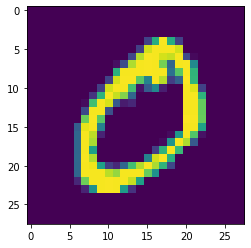

In [10]:
plt.imshow(train_data[1][0][0])

In [11]:
transforms.Resize(size=14)(train_data.data)

tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,  94,   0,   0],
         ...,
         [  0,   0,  57,  ...,   0,   0,   0],
         [  0,   0,  97,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,  10,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        ...,

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]

In [12]:
type(train_data)

torchvision.datasets.mnist.MNIST

/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


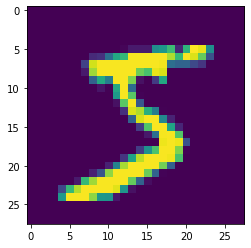

In [13]:
plt.imshow(train_data.train_data[0])

In [14]:
# Resize(size[, interpolation, max_size, …])

/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


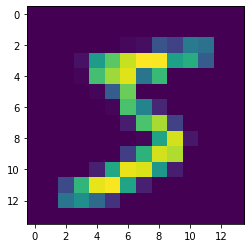

In [15]:
resized = transforms.Resize(size=14)(train_data.train_data)
plt.imshow(resized[0])

In [16]:
type(resized)

torch.Tensor

In [17]:
resized_28 = transforms.Resize(size=28)(train_data.train_data)
resized_14 = transforms.Resize(size=14)(train_data.train_data)
resized_7 = transforms.Resize(size=7)(train_data.train_data)
resized_4 = transforms.Resize(size=4)(train_data.train_data)

/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


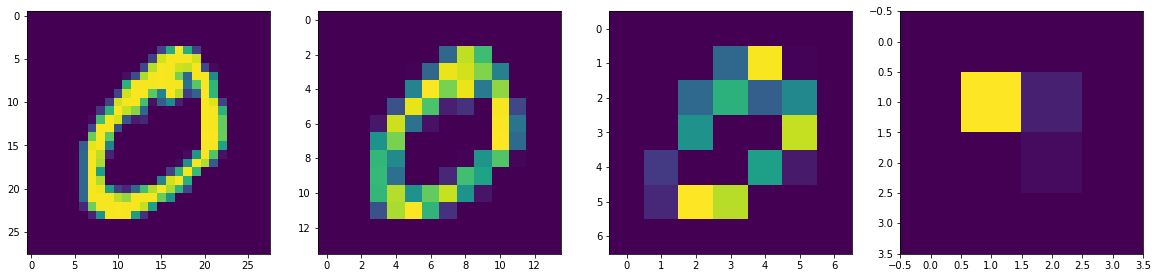

In [18]:
index = 1
f, axarr = plt.subplots(1,4, figsize=(20,5))
axarr[0].imshow(resized_28[index])
axarr[1].imshow(resized_14[index])
axarr[2].imshow(resized_7[index])
axarr[3].imshow(resized_4[index])

<h1>Using Pytorch's Data loaders to feed data into CNN</h1>

In [19]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f92cac24860>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f92ed6bbc88>}

<h1>Defining the CNN</h1>

In [48]:
class CNN(nn.Module):
    def __init__(self, img_shape = 28, conv_layers = 2, num_classes = 10):
        super(CNN, self).__init__()
        
#         self.conv_count = 0   #keeps track of the number of times a conv layer is added
        self.img_shape = img_shape   
        self.num_classes = num_classes
        self.conv_layers = conv_layers
        self.linear_shape = [1, img_shape, img_shape]
        self.conv = []
        
        def conv_out_size(linear_shape, img_shape, conv):
            linear_shape[0] = conv[0].out_channels
            linear_shape[1] = ( (img_shape - conv[0].kernel_size[0] + 2*conv[0].padding[0]) / conv[0].stride[0]) + 1
            img_shape = linear_shape[1]
            linear_shape[2] = linear_shape[1]

            return linear_shape, img_shape


        def pooling_out_size(linear_shape, img_shape, conv):
            linear_shape[1] = ( (img_shape - conv[2].kernel_size) / conv[2].stride) + 1
            img_shape = linear_shape[1]
            linear_shape[2] = linear_shape[1]

            return linear_shape, img_shape

        def flatten(linear_shape):
            return linear_shape[0] * linear_shape[1] * linear_shape[2]
        
        
        
        for i in range(conv_layers):
            if not self.conv:
                layer = nn.Sequential(         
                    nn.Conv2d(
                        in_channels=1,              
                        out_channels=4,            
                        kernel_size=3,              
                        stride=1,                   
                        padding=0,                  
                    ),                              
                    nn.ReLU(),                      
                    nn.MaxPool2d(kernel_size=2),    
                )
                
            else:
                layer = nn.Sequential(         
                    nn.Conv2d(
                        in_channels = self.conv[i-1][0].out_channels,              
                        out_channels = self.conv[i-1][0].out_channels * 2,            
                        kernel_size = 3,              
                        stride = 1,                   
                        padding=0,                  
                    ),                              
                    nn.ReLU(),                      
                    nn.MaxPool2d(kernel_size=2),    
                )
            
            self.conv.append(layer)
#             self.conv_count += 1
            
            self.linear_shape, self.img_shape = conv_out_size(self.linear_shape, self.img_shape, self.conv[i])
            self.linear_shape, self.img_shape = pooling_out_size(self.linear_shape, self.img_shape, self.conv[i])
            
            continue
        
        # input to Linear layer MUST be an integer!!
        self.out_shape = int(flatten(self.linear_shape))
        self.out = nn.Linear(self.out_shape, self.num_classes)
        
        
    def forward(self, x):
        for i in range(len(self.conv)):
            x = self.conv[i](x)
            
        # flatten the output of conv2 to (batch_size, 32 * 4 * 4)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
    
    

In [49]:
cnn = CNN(14)
cnn

CNN(
  (out): Linear(in_features=32, out_features=10, bias=True)
)

In [22]:
cnn.out_shape

512

In [23]:
32*4*4

512

In [24]:
layer = nn.Sequential(         
                    nn.Conv2d(
                        in_channels=1,              
                        out_channels=16,            
                        kernel_size=5,              
                        stride=1,                   
                        padding=0,                  
                    ),                              
                    nn.ReLU(),                      
                    nn.MaxPool2d(kernel_size=2),    
        )

In [25]:
def sum(x, y):
    return x+y, x-y

a, b = sum(2, 5)
print("a = ", a)
print("b = ", b)

a =  7
b =  -3


In [26]:
layer

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [27]:
layer[2].stride

2

In [28]:
# '''
#         Goes through two layers of 2D convolutions, each followed by a 2x2 max pooling
        
#         Dimensions:
#         1.) Input Shape:          [batch_size, 1, 28, 28]
        
#         2.) After conv:           [batch_size, 16, 24, 24]
#             After max pooling:    [batch_size, 32, 12, 12]
        
#         3.) After conv:           [batch_size, 16, 12, 12]
#             After max pooling:    [batch_size, 32, 4, 4]
            
#         4.) After flattening:     [batch_size, 32 * 4 * 4]
#         '''

# img_shape = 28
# in_channels = [1, 16]
# out_channels = [16, 32]
# conv_ker_size = 5
# pool_ker_size = 2
# linear = [1, img_shape, img_shape]

# def conv_out_size(linear, img_shape, conv_ker_size):
#     linear[0] = out_channels[]
#     linear[1] = ( (img_shape - conv_ker_size + 2*padding) / stride) + 1
#     linear[2] = linear[1]
    
#     return 

# def pooling_out_size(in_shape):
#     return ( (in_shape[1] - pool_ker_size) / stride) + 1

In [29]:
# cnn = CNN(28)
# print(cnn)

In [30]:
loss_func = nn.CrossEntropyLoss(); print(loss_func)   
optimizer = torch.optim.Adam(cnn.parameters(), lr= 1e-5); print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)


<h1>Training the CNN</h1>
<div>Error source may be that the dataset resized_28 doesn't have 'labels', just 'images' ---> (for i, (images, labels))</div>

In [50]:
def train(num_epochs, cnn, loaders):
    
    cnn.train()
    
    train_acc_data = []
    loss_data = []
    # Train the model
    total_step = len(loaders['train'])    
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # measure accuracy and record loss
            train_output, last_layer = cnn(images)
            pred_y = torch.max(train_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), accuracy))
                
            if (i+1) % 600 == 0:
                train_acc_data.append(accuracy)
                loss_data.append(loss)
            pass
        
        pass
    
    
    pass



In [51]:
%%time
num_epochs = 10
train(num_epochs, cnn, loaders)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x200 and 32x10)

<h2>Are the two following cells reaching the same result over different procedures?</h2>

In [33]:
test_acc_data = []

def test():
    cnn.eval()
        
    # Test the model
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
#         print(pred_y)
#         print("len(output) = ", len(output))
        
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        test_acc_data.append(accuracy)
#         print("Accuracy: {:.4f}".format(accuracy))
        
#         y_pred.extend(test_output)
        
#         labels = labels.data.cpu().numpy()
#         y_true.extend(labels)
        
    
#     classes = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")
    
#     cf_matrix = confusion_matrix(y_true, y_pred)
#     df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                          columns = [i for i in classes])
#     plt.figure(figsize = (12,7))
#     sn.heatmap(df_cm, annot=True)
#     plt.savefig('output.png')
        
#     print('Test Accuracy: %.2f' % accuracy)

In [34]:
%%time
test()

CPU times: user 1.32 s, sys: 107 ms, total: 1.42 s
Wall time: 2.03 s


output_AFTER =  [3 8 8 7 3 4 4 8 7 0 0 8 8 0 8 6 7 8 8 0 4 1 9 4 3 6 1 3 9 4 3 6 8 8 0 8 1
 1 2 4 1 6 0 9 8 4 2 0 8 8 4 8 4 8 4 2 8 0 2 4 1 2 1 1 1 4 3 6 2 1 4 2 0 8
 0 3 1 0 6 9 4 0 4 4 9 2 0 2 3 8 0 1 6 3 4 2 9 6 8 6]
len(output) =  100 

output_AFTER =  [3 0 4 1 1 1 9 0 4 0 6 1 9 3 3 7 7 8 8 3 7 1 0 2 3 9 6 3 1 1 4 9 6 0 3 4 7
 9 4 9 2 3 9 4 3 1 8 0 1 6 8 4 6 1 2 8 4 2 4 4 6 3 7 7 3 9 1 4 8 8 8 0 3 9
 9 6 1 2 1 1 0 8 4 1 8 2 6 3 6 0 4 9 9 8 0 3 4 7 2 4]
len(output) =  100 

output_AFTER =  [7 3 6 3 9 8 8 3 4 1 8 4 1 1 6 4 4 0 8 9 9 2 8 8 7 8 7 3 6 3 8 0 8 0 0 4 8
 6 4 6 1 1 1 2 2 8 9 1 2 9 6 1 0 4 3 0 4 0 2 4 6 1 8 6 0 3 8 0 8 8 1 3 7 4
 2 7 8 8 4 1 9 0 1 9 8 7 1 3 0 6 1 6 6 7 4 1 9 0 6 9]
len(output) =  100 

output_AFTER =  [7 8 8 2 4 1 0 6 1 3 9 6 0 4 0 9 4 0 8 1 6 8 1 3 2 3 1 3 8 9 1 8 6 1 3 2 9
 4 6 3 9 1 0 4 2 2 0 7 8 8 2 8 1 3 1 0 3 0 1 4 0 6 3 9 0 6 7 0 1 9 8 2 4 4
 6 0 1 8 3 3 6 0 1 2 4 8 1 1 8 7 6 8 0 4 2 2 4 6 6 1]
len(output) =  100 

output_AFTER =  [3 1 3 6 6 9 3 9 0 1

output_AFTER =  [9 4 9 1 0 1 2 6 1 0 3 0 3 1 0 0 8 9 9 3 6 3 6 2 0 1 1 4 1 8 0 6 1 6 0 4 2
 4 0 3 9 7 8 9 0 3 9 3 2 8 1 1 7 2 8 3 9 6 7 6 9 8 6 2 8 2 3 3 3 8 1 3 2 4
 6 8 6 2 6 9 6 7 3 3 7 2 4 6 8 8 0 0 0 1 1 3 8 4 1 8]
len(output) =  100 

output_AFTER =  [8 2 9 8 6 0 1 4 4 8 8 9 0 0 4 4 0 1 8 2 8 4 3 6 6 3 4 1 1 8 9 8 7 4 2 4 8
 8 4 8 8 2 6 9 9 0 1 6 8 0 3 8 8 9 8 3 4 0 8 3 6 8 4 3 0 3 4 1 8 9 2 1 2 1
 2 8 9 8 6 3 1 9 9 2 6 1 9 8 8 8 8 6 3 1 8 8 8 0 4 1]
len(output) =  100 

output_AFTER =  [1 8 0 0 4 1 3 7 6 6 6 8 3 6 9 3 0 9 6 2 3 6 4 2 8 9 0 9 1 6 9 0 9 8 6 6 0
 1 6 6 4 9 6 8 3 2 8 3 8 4 7 6 8 2 1 7 7 2 8 8 7 1 2 0 2 9 4 2 0 3 3 6 6 0
 2 9 9 8 6 8 3 9 6 8 1 4 8 0 6 4 9 7 3 9 6 7 2 2 1 1]
len(output) =  100 

output_AFTER =  [8 3 0 9 6 1 7 0 0 9 1 1 8 6 1 8 9 9 2 7 4 6 8 4 6 3 0 6 7 6 6 1 6 0 4 8 1
 8 7 9 9 9 4 0 9 7 1 1 8 1 3 8 3 1 4 0 3 1 4 0 9 1 1 8 8 8 2 9 0 4 1 9 7 9
 0 3 4 0 6 4 8 7 2 7 1 0 0 7 4 8 0 6 0 7 8 7 4 1 2 6]
len(output) =  100 

output_AFTER =  [1 9 0 1 2 1 2 1 6 9

output_AFTER =  [7 8 1 4 4 8 0 0 7 3 1 2 0 8 6 2 3 0 6 8 9 2 8 8 8 0 7 0 1 2 2 2 7 6 4 8 7
 9 0 0 9 7 1 8 3 2 1 9 8 9 0 4 9 8 7 8 3 7 7 7 8 3 8 9 3 6 2 0 8 7 1 0 1 3
 8 3 8 6 7 0 0 1 8 4 8 9 0 9 0 7 9 7 8 4 1 0 2 6 2 3]
len(output) =  100 

output_AFTER =  [1 9 6 4 9 8 8 9 8 8 9 9 6 3 3 6 1 9 0 8 9 1 0 6 4 8 0 2 0 0 7 2 8 3 0 0 8
 9 1 0 7 2 8 1 2 2 2 0 3 9 1 1 8 2 6 6 3 4 7 9 7 1 4 8 0 7 0 8 6 1 9 1 6 8
 2 1 7 3 7 6 1 3 9 2 7 1 8 6 2 4 7 6 9 6 9 1 3 6 8 8]
len(output) =  100 

output_AFTER =  [7 7 0 9 7 9 0 1 9 8 4 8 0 3 0 6 1 8 6 2 3 3 8 8 4 2 7 1 3 6 0 6 1 4 9 4 6
 9 8 3 6 4 7 8 6 8 3 2 9 1 4 2 2 8 9 0 1 0 2 1 2 0 2 4 0 4 0 0 8 3 1 3 7 0
 9 8 0 0 7 1 1 6 3 1 1 4 9 2 8 8 8 1 6 6 1 8 0 0 3 3]
len(output) =  100 

output_AFTER =  [6 9 4 1 2 8 7 4 2 0 3 4 7 1 9 3 0 4 3 7 2 2 2 6 1 6 2 1 7 2 1 2 4 7 8 1 6
 1 0 8 3 2 9 2 6 9 9 1 7 9 1 3 1 8 1 6 8 2 7 8 3 7 1 8 0 2 0 9 6 8 3 8 9 1
 8 1 7 1 0 0 4 9 0 0 1 6 6 4 0 3 8 7 8 1 3 3 9 0 0 9]
len(output) =  100 

output_AFTER =  [9 9 1 8 8 4 3 3 1 8

<AxesSubplot:>

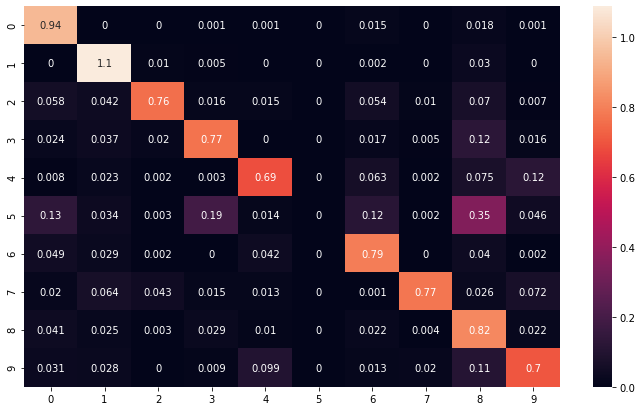

In [35]:
y_pred = []
y_true = []

for inputs, labels in loaders['test']:
        output = cnn(inputs) # Feed Network
#         print("output_BEFORE: ", output)

        output = (torch.max(torch.exp(output[0]), 1)[1]).data.cpu().numpy()
        print("output_AFTER = ", output)
        print("len(output) = ", len(output), "\n")
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

<h2>Plotting Metrics</h2>

NameError: name 'train_acc_data' is not defined

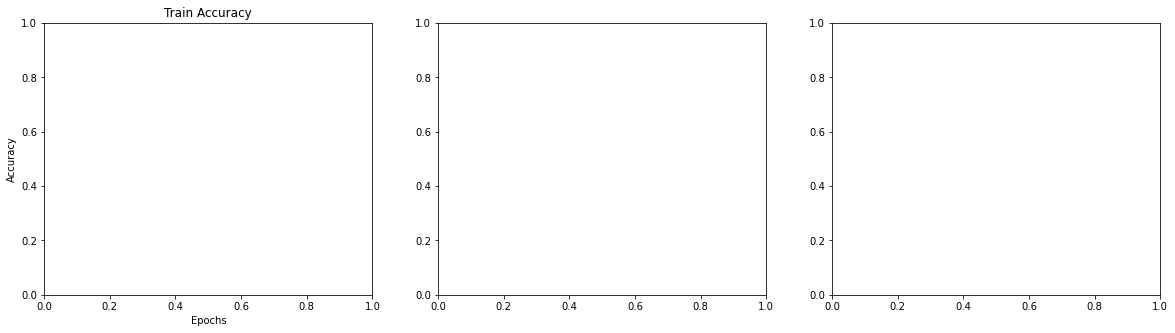

In [36]:
f, axarr = plt.subplots(1,3, figsize=(20, 5))
axarr[0].set_title("Train Accuracy")
axarr[0].set_xlabel("Epochs")
axarr[0].set_ylabel("Accuracy")
axarr[0].plot(train_acc_data)

axarr[1].set_title("Test Accuracy")
axarr[1].set_xlabel("Epochs")
axarr[1].set_ylabel("Accuracy")
axarr[1].plot(test_acc_data)


axarr[2].set_title("Loss")
axarr[2].set_xlabel("Epochs")
axarr[2].set_ylabel("Loss Value")
axarr[2].plot(loss_data)


What's the difference between `torch.save(the_model.state_dict(), PATH)` and `torch.save(model, PATH)`?

In [ ]:
f = "data"
torch.save(cnn, f)

In [ ]:
model = torch.load(f)
model.eval()
model

In [ ]:
f = "data2"
torch.save(cnn.state_dict(), f)
model = torch.load(f)
model

In [ ]:
cnn.train()
len(loaders['train'])

In [ ]:
type(train_data)

In [ ]:
type(resized_28)

<h1>Attempting to resize the dataset when importing with datasets.MNIST</h1>

In [ ]:
# train_data = datasets.MNIST(
#     root = 'data',
#     train = True,                         
#     transform = transforms.Compose([
#                     transforms.ToTensor(),
#                     transforms.Resize(size=14)(train_data.data),
#                     transforms.Normalize(0, 1)
#                 ]), 
#     download = True,            
# )
# test_data = datasets.MNIST(
#     root = 'data', 
#     train = False, 
#     transform = transforms.Compose([
#                     transforms.ToTensor(),
#                     transforms.Resize(size=14)(test_data.data),
#                     transforms.Normalize(0, 1)
#                 ]) 
# )

In [ ]:
train_data.data.shape